# 1.Load data

Please download the dataset ner_dataset.csv from https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus

In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('./archive/ner_dataset.csv', encoding= 'unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [4]:
data.shape

(1048575, 4)

We can see that the sentences are broken into tokens in the column 'Word'. The column 'sentence #' displays the sentence number once and then prints NaN till the next sentence begins.

## 2. Extract mappings required for the neural network
To train a neural network, we will use two mappings as given below. The neural network will only take integers as input. So lets convert all the unique tokens in the corpus to its respective index.
- {token} to {token id}: address the row in embeddings matrix for the current token.
- {tag} to {tag id}: one-hot ground truth probability distribution vectors for computing the loss at the output of the network.

In [5]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

In [6]:
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx) 

In [7]:
data.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,22712,16
1,NaN,of,IN,O,32833,16
2,NaN,demonstrators,NNS,O,6038,16
3,NaN,have,VBP,O,23582,16
4,NaN,marched,VBN,O,19558,16


## 3. Transform columns to extract sequential data
Next, lets fill NaN in 'sentence #' column using method ffill in fillna. Thereafter groupby on the sentence column to get a list of tokens and tags for each sentence.

In [8]:
data.isna().any()

Sentence #     True
Word           True
POS           False
Tag           False
Word_idx      False
Tag_idx       False
dtype: bool

In [11]:
data_fillna = data.fillna(method='ffill', axis=0)
data_group = data_fillna.groupby(['Sentence #'], as_index=False)[['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx']].agg(lambda x: list(x))

data_group.head()

C:\Users\hp\AppData\Local\Temp\ipykernel_19584\450957418.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fillna = data.fillna(method='ffill', axis=0)


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[22712, 32833, 6038, 23582, 19558, 13631, 2128...","[16, 16, 16, 16, 16, 16, 2, 16, 16, 16, 16, 16..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[31258, 775, 22676, 15913, 31158, 4550, 33501,...","[5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[30771, 11600, 32572, 24898, 3426, 8923, 15313...","[16, 16, 8, 16, 16, 16, 16, 16, 2, 16, 16, 16,..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[34797, 17432, 16834, 7186, 1875, 12516, 28168...","[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[894, 22131, 34707, 32557, 19922, 11238, 16724...","[2, 16, 16, 0, 15, 16, 8, 16, 2, 16, 5, 16, 5,..."


## 4. Pad sequences and split the dataset into train, test
Padding: The LSTM layers accept sequences of same length only. Therefore we will want to transform our list of token_sequences ('Word_idx') which is lists of integers into a matrix of shape (token_sequences, max_len). We can use any length as max_len. In this project we will be using length of the longest sequence as max_len. The sequences that are shorter than max_len are padded with a specified value at the end.
Import required packages

In [14]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [15]:
def get_pad_train_test_val(data_group, data):
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))
    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)
    
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    
    train_tokens, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntrain_tags:', len(train_tags),
        '\ntest_tags:', len(test_tags)
    )
    
    return train_tokens, test_tokens, train_tags, test_tags

train_tokens, test_tokens, train_tags, test_tags = get_pad_train_test_val(data_group, data)

train_tokens length: 43163 
test_tokens length: 4796 
train_tags: 43163 
test_tags: 4796


In [16]:
for token, tag in zip(train_tokens[0], train_tags[0]):
    print('%s\t%s' % (token, tag))

4279	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
22676	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
716	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
18713	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
10742	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
24401	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
4550	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
21969	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
16088	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
6269	[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
10050	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
6513	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
15913	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
12133	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
33331	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
32728	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
32056	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
949

## 5. Build Model Layout

Lets go through the process of building a neural network model with lstm layers. Please compare the layers brief and model plot given below to get a better understanding of the layers, input and output dimensions. We are building a simple model with 4 layers.

- **Layer 1 - Embedding layer** : We will feed the padded sequences of equal length (104) to the embedding layer. Once the network has been trained, each token will get transformed into a vector of n dimensions. We have chosen the n dimensions to be (64). 


These are the dimensions (?, 104, 64) plotted in the model plot for input layer and embedding layer. The ? or None in the dimension specifies batches, when it is None or ? the model can take any batch size.

- **Layer 2 - Bidirectional LSTM** : Bidirectional lstm takes a recurrent layer (e.g. the first LSTM layer) as an argument. This layer takes the output from the previous embedding layer (104, 64). It also allows you to specify the merge mode, that is how the forward and backward outputs should be combined before being passed on to the next layer. The default mode is to concatenate, where the outputs are concatenated together, providing double the number of outputs to the next layer, in our case its 128(64 * 2).


The output dimension of the bidirectional lstm layer (?, 104, 128) becomes the input dimension of the next lstm layer.

- **Layer 3 - LSTM Layer** : An LSTM network is a recurrent neural network that has LSTM cell blocks in place of our standard neural network layers. These cells have various components called the input gate, the forget gate and the output gate.


This layer takes the output dimension from the previous bidirectional lstm layer (?, 104, 128) and outputs (?, 104, 256)



- **Layer 4 - TimeDistributed  Layer** : We are dealing with Many to Many RNN Architecture where we expect output from every input sequence for example (a1 →b1, a2 →b2… an →bn) where a and b are inputs and outputs of every sequence. The TimeDistributeDense layers allow you to apply Dense(fully-connected) operation across every output over every time-step. If you don't use this, you would only have one final output.



This layer take the output dimension of the previous lstm layer (104, 256) and outputs the max sequence length (104) and max tags (17).

In [17]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

# import keras as k

In [18]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [19]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 32
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  35179 
output_dim:  32 
input_length:  104 
n_tags:  17


In [20]:
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser 
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [23]:
def train_model(X, y, model):
    loss = list()
    for _ in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)

E:\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [22]:
results = pd.DataFrame()
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

35/35 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.6975 - loss: 2.1064 - val_accuracy: 0.9679 - val_loss: 0.3765
35/35 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9677 - loss: 0.4074 - val_accuracy: 0.9679 - val_loss: 0.3524
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9677 - loss: 0.3812 - val_accuracy: 0.9679 - val_loss: 0.3457
35/35 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9677 - loss: 0.3506 - val_accuracy: 0.9679 - val_loss: 0.3114
35/35 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9678 - loss: 0.3358 - val_accuracy: 0.9680 - val_loss: 0.2881
35/35 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.9678 - loss: 0.3152 - val_accuracy: 0.9681 - val_loss: 0.2970
35/35 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.9679 - loss: 0.3108 - val_accuracy: 0.9680 - val_loss: 0.2680
35/35 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9679 - loss: 0.2926 - val_accuracy: 0.9680 - val_loss: 0.2580
35/35 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.9679 - loss: 0.2775 - val_a

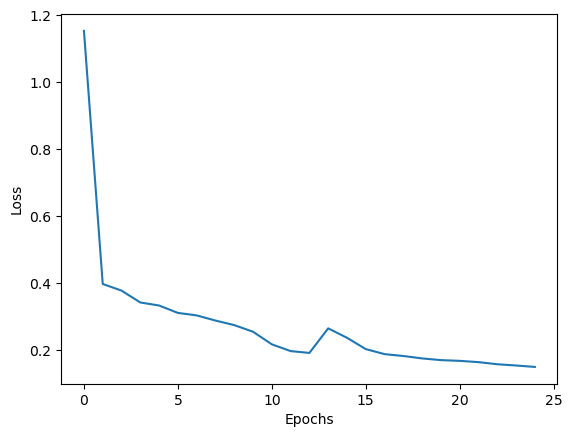

In [24]:
import matplotlib.pyplot as plt
plt.plot(results['with_add_lstm'])
plt.xlabel('Epochs');
plt.ylabel('Loss');

Model started with 0.9169 accuracy ended. After running 25 epochs with 1000 batch size, the final accuracy was 0.9687. Please experiment the model with different batch sizes, dropout value, optimisers, metrics and layers to get better result.

## spaCy entities

In [26]:
!uv pip install spacy

Using Python 3.12.3 environment at E:\anaconda3
Resolved 41 packages in 2.36s
Prepared 20 packages in 3.98s
Uninstalled 1 package in 1.75s
         If the cache and target directories are on different filesystems, hardlinking may not be supported.
         If this is intentional, set `export UV_LINK_MODE=copy` or use `--link-mode=copy` to suppress this warning.
Installed 20 packages in 1.00s
 + blis==1.0.1
 + catalogue==2.0.10
 + cloudpathlib==0.20.0
 + confection==0.1.5
 + cymem==2.0.10
 + langcodes==3.5.0
 + language-data==1.3.0
 + marisa-trie==1.2.1
 + murmurhash==1.0.11
 - numpy==1.26.4 (from file:///C:/b/abs_c1ywpu18ar/croot/numpy_and_numpy_base_1708638681471/work/dist/numpy-1.26.4-cp312-cp312-win_amd64.whl)
 + numpy==2.0.2
 + preshed==3.0.9
 + shellingham==1.5.4
 + spacy==3.8.2
 + spacy-legacy==3.0.12
 + spacy-loggers==1.0.5
 + srsly==2.4.8
 + thinc==8.3.2
 + typer==0.13.1
 + wasabi==1.1.3
 + weasel==0.4.1


In [32]:
!uv pip install --upgrade numpy h5py

Using Python 3.12.3 environment at E:\anaconda3
Resolved 2 packages in 278ms
Prepared 2 packages in 427ms
Uninstalled 2 packages in 418ms
         If the cache and target directories are on different filesystems, hardlinking may not be supported.
         If this is intentional, set `export UV_LINK_MODE=copy` or use `--link-mode=copy` to suppress this warning.
Installed 2 packages in 4.14s
 - h5py==3.11.0 (from file:///C:/b/abs_c4ha_1xv14/croot/h5py_1715094776210/work)
 + h5py==3.12.1
 - numpy==2.0.2
 + numpy==2.1.3


In [33]:
!python -m spacy download en_core_web_sm

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'E:\\anaconda3\\Lib\\site-packages\\numpy\\linalg\\_umath_linalg.cp312-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------------ ------------------------- 20.5/60.8 kB 330.3 kB/s eta 0:00:01
     ------------------------------- ------ 51.2/60.8 kB 525.1 kB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 544.1 kB/s eta 0:00:00
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/12.6 MB 9.6 MB/s eta 0:00:02
   -- ------------------------------------- 0.7/12.6 MB 9.3 MB/s eta 0:00:02
   --- ------------------------------------ 1.2/12.6 MB 9.7 MB/s eta 0:00:02
   ----- ---------------------------------- 1.7/12.6 MB 10.1 MB/s eta 0:00:02
   ------- -------------------------------- 2.2/12.6 MB 10.1 MB/s eta 0:00:02
   -------- ------------------------------- 2.7/12.6 MB 10.2 MB/s eta 0:00:01
   ---------- ----------------------------- 3.2/12.6 MB 10.2 MB/s eta 0:00:01
   ------------ --------------------------- 3.8/12.6 MB 10.5 MB/s eta 0:00:

In [34]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [35]:
text = nlp(
    'Jim bought 300 shares of Acme Corp. in 2006. And producing an annotated block of text that \
    highlights the names of entities: [Jim]Person bought 300 shares of \
    [Acme Corp.]Organization in [2006]Time. In this example, a person name consisting \
    of one token, a two-token company name and a temporal expression have been detected \
    and classified.State-of-the-art NER systems for English produce near-human performance. \
    For example, the best system entering MUC-7 scored 93.39% of F-measure while human \
    annotators scored 97.60% and 96.95%.[1][2]')

In [36]:
for w in text.ents:
    print(w.text, w.label_)

Jim PERSON
300 CARDINAL
Acme Corp. ORG
2006 DATE
300 CARDINAL
Acme Corp.]Organization WORK_OF_ART
2006]Time DATE
one CARDINAL
two CARDINAL
NER ORG
English NORP
MUC-7 ORG
93.39% PERCENT
97.60% PERCENT
96.95%.[1][2 CARDINAL


In [37]:
displacy.render(text, style = 'ent', jupyter=True)

In [38]:
spacy.explain('CARDINAL')

'Numerals that do not fall under another type'